In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
import requests

In [8]:
%%capture
%run -i -e main.ipynb

In [9]:
# Copy relevant data 
selected_clusters = pd.DataFrame(DBSCAN_cluster.copy())
train_data = data.copy()

In [ ]:
# Filter the DataFrame based on the tickers in the specified cluster
selected_data = train_data[selected_clusters["Stock"]]

## Pair Selection
We check the identified clusters for stock pairs. In order to be considered as a pair, the following hypothese have to be met:   
    1. Correlation of stock price evolution of 90% or higher (and different to 1)  
    2. Check if the Cointergration hypothesis is met or not

In [ ]:
#Correlation test
corr = selected_data.corr()
pairs_list = set()

for i in selected_clusters["Cluster"].unique():
    for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == i, "Stock"], 2):
        stock1, stock2 = pair
        correlation = abs(corr[stock1][stock2])

        #Check if Corraelation is significant
        if correlation > 0.9 and correlation != 1:
            coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        
            # Check if the cointegration test is significant
            if coint[1] < 0.05:
                pairs_list.add((stock1, stock2, correlation,1-coint[1]))

sorted_pairs_list = sorted(pairs_list, key=lambda x: x[3]*x[2], reverse=True)

# Take the top 10 pairs with the highest correlation
top_10_pairs = sorted_pairs_list[:10]

# Print the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair[0]+" and "+pair[1]+": Correlation at "+str(pair[2])+" and Cointergation at "+str(pair[3]))
print("\nA total of "+str(len(sorted_pairs_list))+" pairs have been found.")

Top 10 pairs with highest correlation and cointegration:
AME and IEX: Correlation at 0.9895348210168529 and Cointergation at 0.9981550340170154
AWK and NEE: Correlation at 0.9868568115394872 and Cointergation at 0.9978297037556406
ES and WEC: Correlation at 0.9805179496276685 and Cointergation at 0.9975536613887012
CFG and RF: Correlation at 0.9823147370618126 and Cointergation at 0.9861014911475879
DTE and PEG: Correlation at 0.9673594718837637 and Cointergation at 0.9991156230037618
AEP and ETR: Correlation at 0.9713477275501267 and Cointergation at 0.9780128992633823
D and WEC: Correlation at 0.9325603526246881 and Cointergation at 0.9990170390820523
CFG and TFC: Correlation at 0.9632792989459736 and Cointergation at 0.9658750003393122
CMS and D: Correlation at 0.9254266578531388 and Cointergation at 0.999116702185367
D and ES: Correlation at 0.9237335777956273 and Cointergation at 0.9981272897711917

A total of 13 pairs have been found


## Pair Visualization
We reeintroduce the visualization through TSNE in order to inspect the chosen pairs

In [ ]:
#Build DataFrame which collects all TSNE results from concerned stocks
tsne_selected = []
for x,y in ([row[0],row[1]] for row in top_10_pairs):
    tsne_selected.append([x,tsne_result[ret_T.index.get_loc(x),0],tsne_result[ret_T.index.get_loc(x),1]])
    tsne_selected.append([y,tsne_result[ret_T.index.get_loc(y),0],tsne_result[ret_T.index.get_loc(y),1]])

# Convert the list to a set to get unique elements based on the first element of each sub-list
tsne_selected = {tuple(row) for row in tsne_selected}
tsne_selected = list(tsne_selected)
tsne_selected = pd.DataFrame(tsne_selected, columns =["Stock","x","y"])

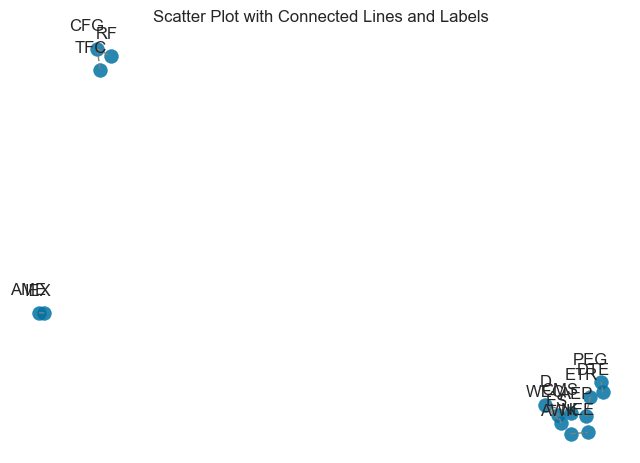

In [ ]:
# Scatter plot
plt.scatter(tsne_selected["x"], tsne_selected["y"], s=100, alpha=0.85, label="Stocks")

# Connect datapoints with lines based on top_10_pairs
for pair in top_10_pairs:
    x1, y1 = tsne_selected.loc[tsne_selected["Stock"] == pair[0], ["x", "y"]].values.flatten()
    x2, y2 = tsne_selected.loc[tsne_selected["Stock"] == pair[1], ["x", "y"]].values.flatten()
    plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--', linewidth=1)

# Annotate each point with its label
for index, row in tsne_selected.iterrows():
    plt.annotate(row["Stock"], (row["x"], row["y"]+1), textcoords="offset points", xytext=(5,5), ha='right')

# Customize the plot as needed
plt.title('Scatter Plot with Connected Lines and Labels')
plt.axis("off")

# Show the plot
plt.show()

